In [ ]:
!pip install rdkit
!pip install jaxtyping
!pip install wget
!pip install git+https://github.com/bp-kelley/descriptastorus
!pip install fair-esm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=babe91af77eb9e9589e594786b0b6d1ba9a790c05517ee66b5b95d12a9d569d7
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Cloning https://github.com/bp-kelley/descriptastorus to /tmp/pip-req-build-s79j69_e
  Running command git clone --filter=blob:none --quiet https://github.com/bp-kelley/descriptastorus /tmp/pip-req-build-s79j69_e
  Resolved https://github.com/bp-kelley/descriptastorus to commit 9b133e2c91bb6a67df53db4cba992776db219ab7
  Preparing metadata (setup.py) ... done
  Created wheel for descriptastorus: filename=descriptastorus-2.5.0.25-py3-none-any.whl size=1083539 sha256=034e6182620ea965f22e94e58bb28bb0bc2c9ec982ecca530ffb4f895c

In [ ]:
import jaxtyping
from jaxtyping import Array, Float, Integer
import dataclasses
import wget
import more_itertools
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

import sklearn
import sklearn.model_selection
import sklearn.metrics

import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.optim as optim
import xgboost as xg

for mod in [np, rdkit, torch, xg, sklearn]:
    print(f'{mod.__name__:<20s} = {mod.__version__}')
USE_CUDA = torch.cuda.is_available()
print(f'has GPU? {USE_CUDA}')

numpy                = 1.25.2
rdkit                = 2024.03.3
torch                = 2.3.1+cu121
xgboost              = 2.0.3
sklearn              = 1.2.2
has GPU? True


# Generate features
## PLM embeddings

Get The Dataframe Ready

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Nate/SAM_Project/Files/SAM_UP45_small_molecules_smiles.csv'
df = pd.read_csv(file_path)
df = df[['Entry', 'Sequence', 'smiles']]

In [ ]:
# Filter the dataframe to keep only the rows with sequences that are less than 1000
df = df[df['Sequence'].str.len() < 1000]
print(df.shape)
df.head()

In [ ]:
from itertools import product

# Get unique values
unique_entries = df[['Entry', 'Sequence']].drop_duplicates()
unique_smiles = df['smiles'].unique()

# Create Cartesian product
combinations = list(product(unique_entries.values.tolist(), unique_smiles))

# Flatten the tuples
flattened_combinations = [(entry_seq[0], entry_seq[1], smile) for entry_seq, smile in combinations]

# Convert to new dataframe
combined_df = pd.DataFrame(flattened_combinations, columns=['Entry', 'Sequence', 'smiles'])

# Display the result
print(combined_df.shape)
combined_df.head()

,Entry,Sequence,smiles
0,A0A061IB80,MQLLWWIPESLEHLLGLSSSEALLGPCSPSPHSYKFVQQPVYNLLM...,OC1=C(O)C(*)=C(*)C(*)=C1*
1,A0A061IB80,MQLLWWIPESLEHLLGLSSSEALLGPCSPSPHSYKFVQQPVYNLLM...,[H][C@]12CC[C@]3(C)[C@@H](O)CC[C@@]3([H])[C@]1...
2,A0A061IB80,MQLLWWIPESLEHLLGLSSSEALLGPCSPSPHSYKFVQQPVYNLLM...,[H][C@]12CC[C@]3(C)[C@@H](O)CC[C@@]3([H])[C@]1...
3,A0A061IB80,MQLLWWIPESLEHLLGLSSSEALLGPCSPSPHSYKFVQQPVYNLLM...,[H][C@]12CC[C@]3(C)C(=O)CC[C@@]3([H])[C@]1([H]...
4,A0A061IB80,MQLLWWIPESLEHLLGLSSSEALLGPCSPSPHSYKFVQQPVYNLLM...,C[C@]12CC[C@H]3[C@@H](CCc4c(O)c(O)ccc34)[C@@H]...


In [ ]:
# Merge the dataframes to find matches
merged_df = combined_df.merge(df, on=['Entry', 'Sequence', 'smiles'], how='left', indicator=True)
merged_df.head()

,Entry,Sequence,smiles,_merge
0,A0A061IB80,MQLLWWIPESLEHLLGLSSSEALLGPCSPSPHSYKFVQQPVYNLLM...,OC1=C(O)C(*)=C(*)C(*)=C1*,both
1,A0A061IB80,MQLLWWIPESLEHLLGLSSSEALLGPCSPSPHSYKFVQQPVYNLLM...,[H][C@]12CC[C@]3(C)[C@@H](O)CC[C@@]3([H])[C@]1...,both
2,A0A061IB80,MQLLWWIPESLEHLLGLSSSEALLGPCSPSPHSYKFVQQPVYNLLM...,[H][C@]12CC[C@]3(C)[C@@H](O)CC[C@@]3([H])[C@]1...,both
3,A0A061IB80,MQLLWWIPESLEHLLGLSSSEALLGPCSPSPHSYKFVQQPVYNLLM...,[H][C@]12CC[C@]3(C)[C@@H](O)CC[C@@]3([H])[C@]1...,both
4,A0A061IB80,MQLLWWIPESLEHLLGLSSSEALLGPCSPSPHSYKFVQQPVYNLLM...,[H][C@]12CC[C@]3(C)C(=O)CC[C@@]3([H])[C@]1([H]...,both


In [ ]:
# Create the Activity column
combined_df['Activity'] = merged_df['_merge'].apply(lambda x: 1 if x == 'both' else 0)
combined_df.head()

,Entry,Sequence,smiles,Activity
0,A0A061IB80,MQLLWWIPESLEHLLGLSSSEALLGPCSPSPHSYKFVQQPVYNLLM...,OC1=C(O)C(*)=C(*)C(*)=C1*,1
1,A0A061IB80,MQLLWWIPESLEHLLGLSSSEALLGPCSPSPHSYKFVQQPVYNLLM...,[H][C@]12CC[C@]3(C)[C@@H](O)CC[C@@]3([H])[C@]1...,1
2,A0A061IB80,MQLLWWIPESLEHLLGLSSSEALLGPCSPSPHSYKFVQQPVYNLLM...,[H][C@]12CC[C@]3(C)[C@@H](O)CC[C@@]3([H])[C@]1...,1
3,A0A061IB80,MQLLWWIPESLEHLLGLSSSEALLGPCSPSPHSYKFVQQPVYNLLM...,[H][C@]12CC[C@]3(C)C(=O)CC[C@@]3([H])[C@]1([H]...,1
4,A0A061IB80,MQLLWWIPESLEHLLGLSSSEALLGPCSPSPHSYKFVQQPVYNLLM...,C[C@]12CC[C@H]3[C@@H](CCc4c(O)c(O)ccc34)[C@@H]...,1


In [ ]:
sample_1_df = combined_df[combined_df['Activity'] == 1].copy()
print(combined_df[combined_df['Activity'] == 1].shape)

In [ ]:
sample_0_df = combined_df[combined_df['Activity'] == 0].sample(4272).copy()

combined_df_save = combined_df.copy()
combined_df = pd.concat([sample_1_df, sample_0_df])

combined_df.shape

# Count how many 0s there are in combined_df[‘Activity’]
print((combined_df['Activity'] == 0).sum())

In [ ]:
# prompt: Give me the sequences in df that map to more than one smiles

# Group the combined dataframe by 'Sequence' and count the number of unique smiles
sequence_smiles_counts = df.groupby('Sequence')['smiles'].nunique()

# Filter for sequences that map to more than one smiles
sequences_with_multiple_smiles = sequence_smiles_counts[sequence_smiles_counts > 1].index.tolist()

# Get the sequences from the original dataframe
sequences_in_df = df[df['Sequence'].isin(sequences_with_multiple_smiles)]

sequences_in_df['Entry'].value_counts()

# Count how many times there is a 1 in ‘Activity’ in rows with ‘A0A3Q7GYG2’ in ‘Entry’ in combined_df

print((combined_df[combined_df['Entry'] == 'A0A3Q7GYG2']['Activity'] == 1).sum())

Entry
A0A3Q7GYG2    9
A0A3Q7HYF0    9
F2YTN5        9
M9Z1G5        8
K0II72        8
             ..
Q96WX4        2
Q5C9L7        2
Q6SKR2        2
Q6T1F5        2
Q84KK4        2
Name: count, Length: 321, dtype: int64

In [ ]:
original_df = df.copy()
df = combined_df.copy()

In [ ]:
class Constants:
    label = 'Activity'
    smiles = 'smiles'
    proteins = 'Sequence'
    batch_size = 128

_C = Constants()

In [ ]:
seqs = np.unique(df[_C.proteins].to_numpy(str))
smiles = np.unique(df[_C.smiles].to_numpy(str))
prot_index = {f'P{i}':s for i,s in enumerate(seqs)}
mol_index = {f'M{i}':s for i,s in enumerate(smiles)}
inverse_map = {v:k for k,v in prot_index.items()}
df['P_index'] = df[_C.proteins].map(inverse_map)
inverse_map = {v:k for k,v in mol_index.items()}
df['M_index'] = df[_C.smiles].map(inverse_map)
pair_indices = list(df[['P_index', 'M_index']].itertuples(index=False, name=None))
y = df[_C.label].to_numpy(np.float32)
print(f'Unique proteins       : {len(seqs)}')
print(f'Unique molecules      : {len(smiles)}')
print(f'Protein/molecule pairs: {len(y)}')
print(df.shape)
df.head()

Unique proteins       : 529
Unique molecules      : 214
Protein/molecule pairs: 6408


Getting Embeddings Using ESM

In [ ]:
import esm
model_name = 'esm2'
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
if USE_CUDA:
    model = model.cuda()
model.eval()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [ ]:
batch_size = 1
tok_seq = {}
mean_seq = {}
batcher = more_itertools.chunked(list(prot_index.items()), batch_size)
for batch in tqdm( batcher, total=len(seqs)//batch_size):
    batch_labels, batch_strs, batch_tokens = batch_converter(batch)
    tokens = batch_tokens.cuda() if USE_CUDA else batch_tokens
    with torch.no_grad():
        results = model(tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]
    for i, (key, seq) in enumerate(batch):
        rep = token_representations[i, 1 : len(seq) + 1].cpu().numpy().astype(np.float32)
        mean_seq[key] = np.mean(rep, axis=0)
        tok_seq[key] = rep

  0%|          | 0/529 [00:00<?, ?it/s]

Getting Embeddings Using a .h5 File

In [ ]:
SAM_prott5_file = '/content/drive/MyDrive/Nate/SAM_Project/Files/h5_files/SAM_UP45.h5'

In [ ]:
import h5py

def get_embeds (SAM_prott5_file, df):
    entries_list = []
    embeddings_list = []
    data_map = {}

    with h5py.File(SAM_prott5_file, "r") as file:
        for sequence_id, embedding in file.items():
            entries_list.append(sequence_id)
            embeddings = np.array(embedding)
            embeddings_list.append(embeddings)
            data_map[sequence_id] = embeddings

    SAM_prott5_df = df
    SAM_prott5_df['Embeddings'] = SAM_prott5_df['Entry'].map(data_map)

    #Remove proteins without embeddings from the dataframe
    SAM_prott5_df = SAM_prott5_df.dropna(subset=['Embeddings'])

    return(SAM_prott5_df, data_map)

In [ ]:
#Updated dfs with the Prott5 embeddings for each protein
df, data_map = get_embeds(SAM_prott5_file, df)

print(df['Embeddings'][0].shape)
df.head()

In [ ]:
# Make a tok_seq dictionary that contains the values in ‘P_index’ and “Embeddings’ values in the dataframe

tok_seq = dict(zip(df['P_index'], df['Embeddings']))

print(tok_seq['P1'])
print(mol_index['M1'])

Getting Normalized Descriptors

In [ ]:
from descriptastorus.descriptors import rdNormalizedDescriptors

generator = rdNormalizedDescriptors.RDKit2DNormalized()
mol_feats= {k: np.array(generator.process(s))[1:].astype(np.float32) for k,s in tqdm(mol_index.items())}

  0%|          | 0/214 [00:00<?, ?it/s]

[01:10:10] DEPRECATION WARNING: please use MorganGenerator
[01:10:10] DEPRECATION WARNING: please use MorganGenerator
[01:10:10] DEPRECATION WARNING: please use MorganGenerator
[01:10:10] DEPRECATION WARNING: please use MorganGenerator
[01:10:10] DEPRECATION WARNING: please use MorganGenerator
[01:10:10] DEPRECATION WARNING: please use MorganGenerator
[01:10:10] DEPRECATION WARNING: please use MorganGenerator
[01:10:10] DEPRECATION WARNING: please use MorganGenerator
[01:10:10] DEPRECATION WARNING: please use MorganGenerator
[01:10:10] DEPRECATION WARNING: please use MorganGenerator
[01:10:10] DEPRECATION WARNING: please use MorganGenerator
[01:10:10] DEPRECATION WARNING: please use MorganGenerator
[01:10:10] DEPRECATION WARNING: please use MorganGenerator
[01:10:10] DEPRECATION WARNING: please use MorganGenerator
[01:10:10] DEPRECATION WARNING: please use MorganGenerator
[01:10:10] DEPRECATION WARNING: please use MorganGenerator
[01:10:10] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
PROT_DIM = tok_seq['P1'].shape[-1]
MOL_DIM = mol_feats['M1'].shape[0]
N_MOLS = len(smiles)
N_PROTEINS = len(seqs)
SEQ_LEN = np.max([len(s) for s in seqs])
print(f'{PROT_DIM=}')
print(f'{MOL_DIM=}')
print(f'{N_MOLS=}')
print(f'{N_PROTEINS=}')
print(f'{SEQ_LEN=}')
print(f'Positive={np.sum(y)/len(y):.2f}')

PROT_DIM=1280
MOL_DIM=200
N_MOLS=214
N_PROTEINS=529
SEQ_LEN=988
Positive=0.33


Splits:

* stratified
* chemistry-based
* protein-based
* chem/prot-based

In [ ]:
@dataclasses.dataclass
class SplitTuple:
    train: Integer[Array, 'i']
    test:  Integer[Array, 'i']

splits = {}
train_index, test_index = sklearn.model_selection.train_test_split(
    np.arange(len(y)),
    test_size=0.2,
    stratify=y,
)
splits['stratified'] = SplitTuple(
    train=train_index,
    test=test_index
)
splits

{'stratified': SplitTuple(train=array([4820, 3494, 3479, ..., 5282, 6392,    0]), test=array([ 583, 5797, 2062, ..., 3108, 1579, 4005]))}

In [ ]:
from torch.nn.utils.rnn import pad_sequence

class ProtMolMap(torch_data.Dataset):
    def __init__(self, prot_map, mol_map, pair_keys, labels, indices):
        self.prot_map = prot_map
        self.mol_map = mol_map
        self.pair_keys = pair_keys
        self.labels = labels
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        p_key, m_key = self.pair_keys[i]
        return self.prot_map[p_key], self.mol_map[m_key], self.labels[i]

def collate_fn(batch):
    prots = [torch.from_numpy(item[0]) for item in batch]
    mols = torch.Tensor([item[1] for item in batch])
    targets = torch.Tensor([item[2] for item in batch])
    padded_prots = pad_sequence(prots, batch_first=True)
    return padded_prots, mols, targets

split_name = 'stratified'
split = splits[split_name]
train_ds = ProtMolMap(tok_seq, mol_feats, pair_indices, y, split.train)
test_ds = ProtMolMap(tok_seq, mol_feats, pair_indices, y, split.test)
train_data = torch_data.DataLoader(train_ds, batch_size=_C.batch_size, shuffle=True,
                                   collate_fn=collate_fn)
test_data = torch_data.DataLoader(test_ds, batch_size=len(split.test),
                                   collate_fn=collate_fn)

train_ds[0]

In [ ]:
prot_test, mol_test, y_test = next(iter(test_data))
print(prot_test.shape, mol_test.shape, y_test.shape)

print(train_ds[0])
print(np.mean(train_ds[0][0],axis=0))

<ipython-input-33-e840aeb160cd>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  mols = torch.Tensor([item[1] for item in batch])


torch.Size([1282, 988, 1280]) torch.Size([1282, 200]) torch.Size([1282])


# Baseline

In [ ]:
def xg_collate(batch):
    x = torch.Tensor([np.concatenate((np.mean(item[0],axis=0), item[1])) for item in batch])
    # x = torch.Tensor([np.concatenate((item[0], item[1])) for item in batch])
    y = torch.Tensor([item[2] for item in batch])
    return x, y

x_train, y_train = next(iter(torch_data.DataLoader(train_ds,batch_size=len(split.train),
                                                   shuffle=True, collate_fn=xg_collate)))

x_test, y_test = next(iter(torch_data.DataLoader(test_ds, batch_size=len(split.test),
                                                 collate_fn=xg_collate)))
print(x_train.shape, x_test.shape)

torch.Size([5126, 1480]) torch.Size([1282, 1480])


In [ ]:
def evaluate(y_true, y_pred, info=None):
    info = info or {}
    info['auroc'] = sklearn.metrics.roc_auc_score(y_true, y_pred)
    info['AP'] = sklearn.metrics.average_precision_score(y_true, y_pred)
    info['auprc'] = sklearn.metrics.precision_recall_curve(y_true, y_pred)
    return info

model = xg.XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
results = [evaluate(y_test, y_pred,
                    {'model':"baseline",
                     'split':split_name, 'split_part':'test'})]
pd.DataFrame(results)

,model,split,split_part,auroc,AP,auprc
0,baseline,stratified,test,0.644123,0.444921,"([0.3330733229329173, 0.5818181818181818, 1.0]..."


# Modules


In [ ]:
def print_model_params(model):
    print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")
    for name, param in model.named_parameters():
        print(f"{name}: {list(param.shape)} ({param.numel():,})")

In [ ]:
prot_test, mol_test, y_test = next(iter(test_data))
print(prot_test.shape, mol_test.shape, y_test.shape)

torch.Size([1282, 988, 1280]) torch.Size([1282, 200]) torch.Size([1282])


In [ ]:
def avg_emb_fn(x):
    return torch.mean(x, dim=1)

class AttProtEmbed(nn.Module):
    def __init__(self, prot_dim:int, emb_dim:int, dropout_rate:float=0.5, num_heads=8):
        super().__init__()
        self.proj_down = nn.Linear(prot_dim, emb_dim)
        self.cross = nn.MultiheadAttention(
                    embed_dim=emb_dim,
                    num_heads=num_heads,
                    dropout=dropout_rate,
                    batch_first=True,
                )
    def forward(self, x ):
        x = self.proj_down(x)
        global_emb = avg_emb_fn(x).unsqueeze(1)
        att, _ = self.cross(
            query=global_emb, key=x, value=x, need_weights=False)
        return att.squeeze(1)

model = AttProtEmbed(PROT_DIM, 128)
model(prot_test).shape
print_model_params(model)

Model has 230,016 parameters
proj_down.weight: [128, 1280] (163,840)
proj_down.bias: [128] (128)
cross.in_proj_weight: [384, 128] (49,152)
cross.in_proj_bias: [384] (384)
cross.out_proj.weight: [128, 128] (16,384)
cross.out_proj.bias: [128] (128)


In [ ]:
class MolProteinCrossAttention(nn.Module):
    def __init__(self, prot_dim:int, mol_dim:int, emb_dim:int, use_avg_emb:bool,
                 dropout_rate:float=0.25,
                 num_heads:int = 16):
        super().__init__()
        self.use_avg_emb = use_avg_emb
        self.prot_emb = nn.Linear(prot_dim, emb_dim) if use_avg_emb else AttProtEmbed(prot_dim, emb_dim,
                                                                    dropout_rate=dropout_rate,
                                      num_heads=num_heads)
        self.key = nn.Linear(mol_dim, emb_dim)

    def forward(self, x_p, x_m):
        if self.use_avg_emb:
            x_p = avg_emb_fn(x_p)
        query = self.prot_emb(x_p)
        key = self.key(x_m)
        att = torch.einsum('be,be->b', query, key)
        att = torch.sigmoid(att)
        return att

model = MolProteinCrossAttention(PROT_DIM, MOL_DIM, 128, use_avg_emb=False)
y_pred = model(prot_test, mol_test)
assert y_pred.shape == y_test.shape
print_model_params(model)
y_pred

Model has 255,744 parameters
prot_emb.proj_down.weight: [128, 1280] (163,840)
prot_emb.proj_down.bias: [128] (128)
prot_emb.cross.in_proj_weight: [384, 128] (49,152)
prot_emb.cross.in_proj_bias: [384] (384)
prot_emb.cross.out_proj.weight: [128, 128] (16,384)
prot_emb.cross.out_proj.bias: [128] (128)
key.weight: [128, 200] (25,600)
key.bias: [128] (128)


In [ ]:
criterion = nn.BCELoss()
model = MolProteinCrossAttention(PROT_DIM, MOL_DIM, 128, use_avg_emb=False)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

pbar = tqdm(range(num_epochs))
results = []
for epoch in pbar:
    for batch_prot, batch_mol, y_batch in train_data:
        y_pred = model(batch_prot, batch_mol)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        y_pred = model(prot_test, mol_test).numpy()
        result = evaluate(y_test, y_pred,
                    {'epoch':epoch, 'model':"linear_att",
                     'split':split_name, 'split_part':'test'})
        pbar.set_postfix(result)
        results.append(result)

result_df = pd.DataFrame(results)
result_df

  0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: all elements of input should be between 0 and 1

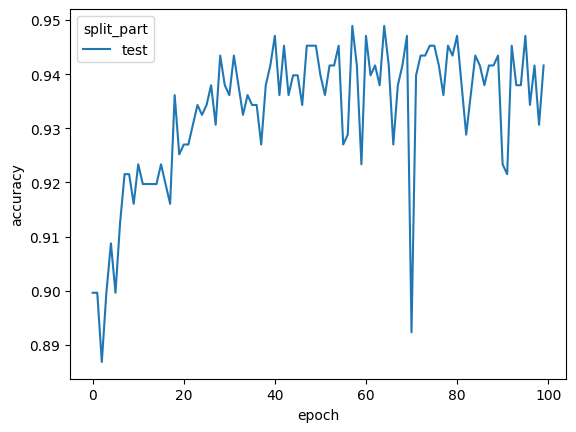

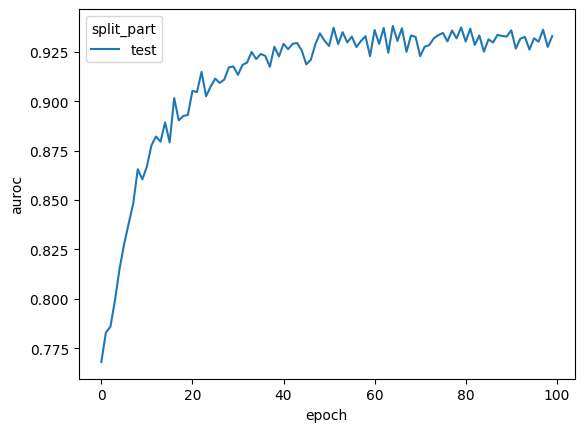

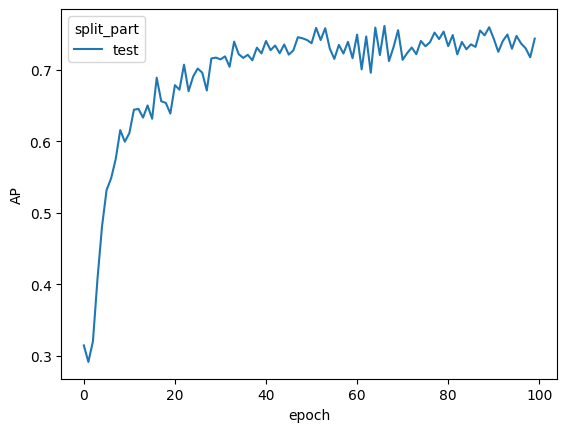

In [ ]:
for m in ['auroc', 'AP']:
    sns.lineplot(data=result_df, x='epoch', y=m, hue='split_part')
    plt.show()